# EMDB dataset exploration
## For the task of EM Map subunit segmentation 



### Import required libraries

In [ ]:
!sudo apt-get update
!pip install SciencePlots
!pip install scikit-learn==0.23.1
!sudo apt install fonts-noto-cjk
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super



Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-noto-cjk is already the newest version (1:20190409+repack1-0ubuntu0.18.04).
0 upgraded, 0 newly installed, 0 to remove and 53 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
cm-super is already the newest version (0.3.4-11).
dvipng is already the newest version (1.15-1).
texlive-fonts-recommended is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
0 upgraded, 0 newly installed, 0 to remove and 53 not upgraded.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import json
import time
import pickle
import matplotlib.font_manager as fm
fm._rebuild()
plt.style.reload_library()
plt.style.use(['science'])


# Read csv and display dataframe sample and statistics


        resolution  contourLevel  subunit_count
count  1045.000000   1045.000000    1045.000000
mean      6.569282     29.527889      13.120574
std       1.633879    369.213033      11.755931
min       4.500000      0.000000       2.000000
25%       4.900000      0.023000       4.000000
50%       6.350000      0.065000       9.000000
75%       7.900000      1.200000      17.000000
max      10.000000   9460.000000      80.000000


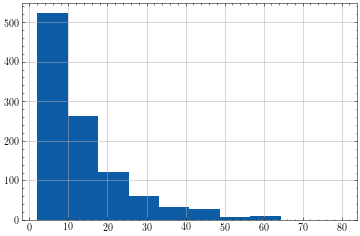

In [ ]:
emdb_df = pd.read_csv('dataset_metadata.csv')


print(emdb_df.describe())
emdb_df['subunit_count'].hist()

       subunit_count  resolution  ...  overlap_after  corr_after
count      73.000000   73.000000  ...      73.000000   73.000000
mean       10.945205    6.855753  ...  124537.410959    0.460788
std        12.310667    1.754235  ...  138892.346270    0.218485
min         2.000000    4.500000  ...       0.000000   -0.001309
25%         4.000000    5.200000  ...   36039.000000    0.319960
50%         7.000000    6.500000  ...   70612.000000    0.469003
75%        12.000000    8.300000  ...  153993.000000    0.614646
max        57.000000   10.000000  ...  637357.000000    0.850218

[8 rows x 11 columns]


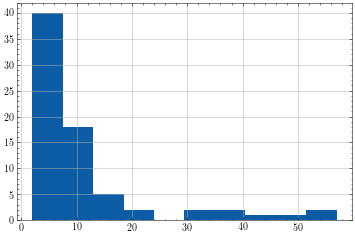

In [ ]:
selected_df = pd.read_csv('dataset_selected.csv')

print(selected_df.describe())
selected_df['subunit_count'].hist()


maps_to_remove = selected_df[selected_df.overlap_after==0].id.tolist()




adjacency_df = pd.read_csv('dataset_selected_adjacency.csv')

for map_id in maps_to_remove:
    selected_df = selected_df[selected_df.id != map_id]
    adjacency_df = adjacency_df[adjacency_df.map_id != map_id]





# Split training data

In [ ]:
from sklearn.model_selection import train_test_split


train, test = train_test_split(selected_df, test_size=0.1, random_state=42)

print(test)
print(test.contourLevel)


           id  ... corr_after
24   emd-3573  ...   0.309554
0    emd-0044  ...   0.377305
51   emd-7090  ...   0.662573
5    emd-0790  ...   0.481603
57   emd-8528  ...   0.257400
20   emd-3206  ...   0.255637
11  emd-20824  ...   0.545070
35   emd-4670  ...   0.709627

[8 rows x 17 columns]
24    0.010
0     5.450
51    0.017
5     0.830
57    0.105
20    0.028
11    0.250
35    0.025
Name: contourLevel, dtype: float64


# Preprocess adjacency to compute vector



In [ ]:
def create_vect_adjacency(row):
    adjacency_json = row['adjacency'] 
    adjacency_dict = eval(adjacency_json)
    number_segments = len(adjacency_dict.keys())
    # Construct vector of verts degree
    degree_v = [ np.sum(list(adjacency_dict[key].values())) for key in adjacency_dict.keys()]
    I = np.identity(number_segments)
    degree_matrix = np.matmul(degree_v,I)
    adjacency_matrix = np.zeros((number_segments,number_segments))
    keys = list(adjacency_dict.keys())
    for i in range(0, number_segments):
        for j in range(0, number_segments):
            if i == j:
                adjacency_matrix[i][j] = 0
            else:
                adjacency_matrix[i][j] = adjacency_dict[keys[i]][keys[j]]
    # Compute Laplacian Matrix
    laplacian_matrix = degree_matrix - adjacency_matrix
    # Compute eigen values and eigen vectors
    eigenValues, eigenVectors = np.linalg.eig(laplacian_matrix)
    # Sort eigenvalues
    idx = eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    flattened = np.ravel(eigenVectors)
    return flattened.tolist()

def get_vect_len(row, column):
    return len(row[column])

def pad_list(row, column, size):
    old_len = len(row[column])
    num_zeros = size-old_len
    old_list = row[column]
    zeros = [ 0 for i in range(num_zeros) ]
    new_list = old_list + zeros
    return new_list

adjacency_df['connectivity'] = adjacency_df.apply(create_vect_adjacency, axis=1).tolist()
vec_len = np.max(adjacency_df.apply(get_vect_len, axis=1, column='connectivity'))
adjacency_df['connectivity'] = adjacency_df.apply(pad_list, axis=1, column='connectivity', size=vec_len).tolist()

print(adjacency_df['connectivity'].describe())
print(adjacency_df.sample(5))

count                                                    71
unique                                                   57
top       [0.0, 1.0, 1.0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
freq                                                      9
Name: connectivity, dtype: object
       map_id  ...                                       connectivity
21   emd-3241  ...  [0.3676256578228848, -0.2755281625035352, 0.33...
45   emd-5223  ...  [0.42344413195733166, 8.752231518030958e-17, 0...
33   emd-4423  ...  [-0.5, -0.06225728063646897, -0.70710678118654...
72  emd-11688  ...  [-0.36313032325414774, 0.6945534765828472, 0.0...
30   emd-3954  ...  [-0.2342198902057247, 0.23293975562225133, -0....

[5 rows x 4 columns]


## Load 

In [ ]:
bad_df = pd.read_csv('segmented_bad.csv')
good_df = pd.read_csv('segmented_good.csv')

tagged_df = bad_df.append(good_df, ignore_index=True)

tagged_df.reindex(np.random.permutation(tagged_df.index))


# Check entries without matched subunits

non_tagged = tagged_df[tagged_df['matched_subunits']==0].id
more_tagged_than_expected = tagged_df[tagged_df['matched_subunits']>60]

print("non tagged {}".format(non_tagged))
print("more than expected {}".format(more_tagged_than_expected))


print(non_tagged)
print(more_tagged_than_expected)

tagged_df = tagged_df[tagged_df['matched_subunits']>0]
tagged_df = tagged_df[tagged_df['matched_subunits']<=60]

# Remove test samples 
print(len(tagged_df))
test_map_id_list = test.id.tolist()
test_df = pd.DataFrame()

for map_id in test_map_id_list:
    test_df = test_df.append(tagged_df[tagged_df.id == map_id]) 
    tagged_df = tagged_df[tagged_df.id != map_id]
    


print(len(test_df))
print(len(tagged_df))

non tagged Series([], Name: id, dtype: object)
more than expected              id  ... label
775   emd-10373  ...  good
1072   emd-4670  ...  good

[2 rows x 16 columns]
Series([], Name: id, dtype: object)
             id  ... label
775   emd-10373  ...  good
1072   emd-4670  ...  good

[2 rows x 16 columns]
1480
167
1313


## Compute statistics show columns, etc

In [ ]:
print(tagged_df.describe())

tagged_df.hist(bins=10, figsize=(20, 15))


tagged_df.boxplot(column=['contourLevel', 'gt_subunits'])
tagged_df_numeric = tagged_df.select_dtypes(include='number')
sns.histplot(tagged_df_numeric, bins=50, kde=True)
plt.show()

       contourLevel  gt_subunits  ...  consistency    homogenity
count   1313.000000  1313.000000  ...  1313.000000  1.313000e+03
mean      18.763380    10.355674  ...     0.494157  4.166262e+19
std      125.555530    10.559533  ...     0.427783  7.128243e+19
min        0.000484     2.000000  ...     0.000000  0.000000e+00
25%        0.010000     4.000000  ...     0.025670  3.718076e-01
50%        0.035000     7.000000  ...     0.669410  6.036486e+01
75%        1.200000    12.000000  ...     0.926189  6.288001e+19
max     1000.000000    57.000000  ...     1.000000  4.658148e+20

[8 rows x 10 columns]


RuntimeError: ignored

<Figure size 1440x1080 with 12 Axes>

## Compute vector of features

### A first vector feature is computed to encode the number of subunits and volume information extracted from annotated data.

### An aditional feature to be used is the Euler Characteristic for each segment, which decribes the topological information of connectivity of each subunit. 


In [ ]:
max_subunit_count = 60

def create_vect_subunit_vol(row):
    segments_volume = row['voxels_assigned']
    segments_volume = eval(segments_volume)
    segment_numbers = [ int(key) for key in segments_volume.keys()]
    segments_volume = [ segments_volume[key] for key in segments_volume.keys()]
    volume = np.sum(segments_volume)
    weigths = [ segment_volume/volume for segment_volume in segments_volume]
    hist = np.histogram(segment_numbers, weights=weigths, bins=max_subunit_count, range=(1,max_subunit_count+1))[0]
    return hist


def create_vect_connectivity(row):
    euler_segments = row['euler_segments']
    euler_segments = eval(euler_segments)
    euler_seg_list = [ euler_segments[key] for key in euler_segments.keys()]
    ft_vector = np.zeros((max_subunit_count))
    ft_vector[:len(euler_seg_list)] = euler_seg_list
    return ft_vector.tolist()


features_df = tagged_df[['id','map_path','gt_subunits','gt_path']]
features_df['vol_subunit'] = tagged_df.apply(create_vect_subunit_vol, axis=1)

# Check for null values or 0

array_to_check = np.array(features_df['vol_subunit'].tolist(), dtype=np.float32)
has_nan = np.any(np.isnan(array_to_check), axis=1)

# Remove nan samples
features_df = features_df[~has_nan]


# Check for zero samples
all_zeroes = np.sum(array_to_check, axis=1)==0
print("Number of samples with only 0s: {}".format(np.sum(all_zeroes)))
print("Number of samples with nan: {}".format(np.sum(has_nan)))

features_df['connectivity'] = tagged_df.apply(create_vect_connectivity, axis=1).tolist()

#features_df['connectivity'] = adjacency_df.apply(create_vect_adjacency, axis=1).tolist()


# Expand vector features from np arrays to column wise dataframe

def expandArray(columns, array):
  df = pd.DataFrame(array, columns=columns)
  return df


cname_vol_vec = ["v"+str(i) for i in range(0,60)]
cname_connectivity_vec = ["c"+str(i) for i in range(0,60)]

subunit_array = np.array(features_df['vol_subunit'].tolist())
conectivity_array = np.array(features_df['connectivity'].tolist())

subunit_array_df = expandArray(cname_vol_vec ,subunit_array)

print(subunit_array_df.sample(5))
print(len(subunit_array_df))

conectivity_array_df = expandArray(cname_connectivity_vec, conectivity_array)
print(conectivity_array_df.sample(5))
print(len(conectivity_array_df))

tagged_df.reset_index(drop=True, inplace=True)
subunit_array_df.reset_index(drop=True, inplace=True)
conectivity_array_df.reset_index(drop=True, inplace=True)

features_df = pd.concat([tagged_df[['matched_subunits']], subunit_array_df], axis=1)
features_df = pd.concat([features_df, conectivity_array_df], axis=1)

print(features_df.sample(5))

print(len(features_df))
print(len(tagged_df))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Number of samples with only 0s: 0
Number of samples with nan: 0
           v0        v1        v2        v3        v4  ...  v55  v56  v57  v58  v59
177  0.027965  0.021490  0.017583  0.114130  0.032201  ...  0.0  0.0  0.0  0.0  0.0
930  0.442659  0.008516  0.548824  0.000000  0.000000  ...  0.0  0.0  0.0  0.0  0.0
153  0.114007  0.120145  0.145112  0.070296  0.024898  ...  0.0  0.0  0.0  0.0  0.0
535  0.051982  0.088628  0.036381  0.004822  0.066187  ...  0.0  0.0  0.0  0.0  0.0
488  0.085421  0.057940  0.083708  0.065640  0.051187  ...  0.0  0.0  0.0  0.0  0.0

[5 rows x 60 columns]
1313
      c0   c1   c2   c3   c4   c5   c6  ...  c53  c54  c55  c56  c57  c58  c59
617  0.0  1.0  0.0  1.0  1.0  1.0  1.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
847  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
999 -3.0  1.0  0.0  0.0  1.0  1.0  1.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
973  1.0  0.0  1.0  1.0  1.0  1.0  1.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0
995 -3.0 

## Compute 

## Normalize data and target encoding



In [ ]:
from sklearn.preprocessing import LabelEncoder
  

normalized_df=(features_df-features_df.min())/(features_df.max()-features_df.min())

le =LabelEncoder()
le.fit(tagged_df.label.tolist())
normalized_df['label'] = le.transform(tagged_df.label.tolist())

print('min')
print(features_df.min().values)
print('max')
print(features_df.max().values)

print(le.classes_)
print(le.transform(le.classes_))



min
[   2.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0. -152.  -56.  -35.  -67.  -29.  -26.  -28.  -40.  -25.  -32.  -32.
  -25.  -16.  -27.  -13.   -9.  -28.  -11.  -14.  -25.  -19.  -13.  -11.
   -8.  -25.  -30.  -30.  -30.  -30.   -6.  -32. -461.   -4.   -3.  -36.
   -3.   -3.   -5.  -11.   -3.   -3.   -5.   -3.   -3.   -4.   -5.   -5.
   -4.   -3.   -2.   -9.   -9.   -6.   -2.   -5.   -5.   -5.    0.    0.
    0.]
max
[6.00000000e+01 9.99681351e-01 7.42918455e-01 9.29050051e-01
 5.21594140e-01 6.34306557e-01 9.29050051e-01 4.94328160e-01
 4.87711935e-01 4.98207008e-01 2.95542122e-01 4.35777611e-01
 3.01317516e-01 2.82279151e-01 4.58980084e-01 4.31133339e-01
 2.3565954

## Split data and k-fold training of models



In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score, make_scorer, plot_roc_curve, auc


def classification_report_cm(y_true, y_pred, clf):
  print(classification_report(y_true, y_pred, labels=le.transform(le.classes_)))
  print(confusion_matrix(y_true, y_pred, labels=le.transform(le.classes_)))
  return accuracy_score(y_true, y_pred)






y = normalized_df['label']
X = normalized_df.drop('label', axis=1)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def train_and_plot_roc(clf, nfolds, X, y):
  cv = StratifiedKFold(n_splits=nfolds)
  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)

  fig, ax = plt.subplots(figsize=(3.5, 2.625))
  for i, (train, test) in enumerate(cv.split(X, y)):
    clf.fit(X[train], y[train])
    viz = plot_roc_curve(clf, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

  ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='#DDAA33',
        label='Chance', alpha=.8)

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)
  ax.plot(mean_fpr, mean_tpr, color='#BB5566',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
  ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
  fig.savefig('train_roc.eps')




## Import GridSearch to find optimal model parameters

In [ ]:
from sklearn.model_selection import GridSearchCV

## Logistic Regression


In [ ]:
from sklearn import linear_model

# Parameter space
C = [0.001,0.01,0.1,1,10,100,1000,10000]
penalty = ['l1', 'l2']
dual=[True,False]
max_iter=[100,110,120,130,140]

param_grid = dict(C=C,penalty=penalty, dual=dual, max_iter=max_iter)

clf = linear_model.LogisticRegression(random_state=42)

grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv = 5, n_jobs=-1, scoring='roc_auc')

start_time = time.time()
grid_result = grid.fit(X_train, y_train)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')


Best: 0.774287 using {'C': 10, 'dual': False, 'max_iter': 120, 'penalty': 'l2'}
Execution time: 6.060771703720093 ms


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## SVM Classifier

In [ ]:
from sklearn import svm

# Parameter space
C = [0.01,0.1,1,10,100,1000]
gamma = [ 0.0001, 0.001, 0.01, 0.1, 1,10]
kernel=['linear', 'poly', 'rbf', 'sigmoid']

param_grid = dict(C=C,gamma=gamma, kernel=kernel)

clf = svm.SVC(random_state=42)

grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv = 5, n_jobs=-1, scoring='roc_auc')

start_time = time.time()
grid_result = grid.fit(X_train, y_train)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')



Best: 0.794826 using {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Execution time: 4459.802588224411 ms


## MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

clf = MLPClassifier(random_state=42, max_iter=1000)
grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv = 5, n_jobs=-1, scoring='roc_auc')

grid_result = grid.fit(X_train, y_train)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')


Best: 0.784772 using {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
Execution time: 6946.878373384476 ms


## Decission Tree

In [ ]:
 from sklearn.tree import DecisionTreeClassifier


param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 15)}
clf = DecisionTreeClassifier(random_state=42)
grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv = 5, n_jobs=-1, scoring='roc_auc')

grid_result = grid.fit(X_train, y_train)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')


Best: 0.735127 using {'criterion': 'gini', 'max_depth': 10}
Execution time: 10192.676264047623 ms


## Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf =  RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200, 300, 500, 700, 900, 1200],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv = 5, n_jobs=-1, scoring='roc_auc')

grid_result = grid.fit(X_train, y_train)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')



Best: 0.831025 using {'max_features': 'auto', 'n_estimators': 1200}
Execution time: 10700.04130601883 ms


## Get ROC for best model

Train ROC


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Test indexes
['emd-1087' 'emd-6979' 'emd-20930' 'emd-8680' 'emd-8682' 'emd-3780'
 'emd-3954' 'emd-1087' 'emd-9272' 'emd-2071' 'emd-5423' 'emd-9621'
 'emd-4412' 'emd-5275' 'emd-11173' 'emd-2100' 'emd-10373' 'emd-4766'
 'emd-11688' 'emd-7117' 'emd-10373' 'emd-2100' 'emd-2071' 'emd-9621'
 'emd-21335' 'emd-4426' 'emd-11688' 'emd-8682' 'emd-8106' 'emd-20047'
 'emd-8336' 'emd-4975' 'emd-4426' 'emd-2638' 'emd-3545' 'emd-9272'
 'emd-8680' 'emd-8300' 'emd-8678' 'emd-3954' 'emd-8886' 'emd-9028'
 'emd-9028' 'emd-5223' 'emd-5423' 'emd-5423' 'emd-9272' 'emd-8106'
 'emd-10960' 'emd-3896' 'emd-11686' 'emd-7065' 'emd-4707' 'emd-5223'
 'emd-9881' 'emd-3896' 'emd-8336' 'emd-4412' 'emd-4232' 'emd-5275'
 'emd-11173' 'emd-4748' 'emd-7065' 'emd-4412' 'emd-3667' 'emd-0251'
 'emd-2537' 'emd-5423' 'emd-6979' 'emd-10255' 'emd-3896' 'emd-20047'
 'emd-10255' 'emd-0251' 'emd-5327' 'emd-1087' 'emd-4232' 'emd-20930'
 'emd-0293' 'emd-10373' 'emd-3896' 'emd-3667' 'emd-7117' 'emd-7065'
 'emd-9272' 'emd-7117' 'emd-4975'

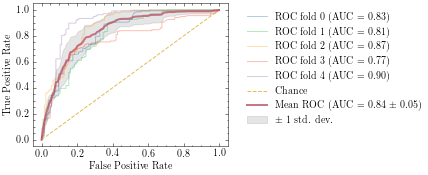

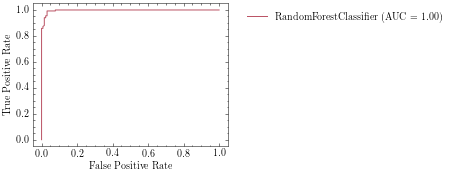

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf =  RandomForestClassifier(random_state=42, n_estimators=1200, max_features='auto')


#train
print("Train ROC")
train_and_plot_roc(clf, 5, X.values, y.values)
#test
print("Test indexes")
print(tagged_df.iloc[X_test.index.values].id.values)

fig, ax = plt.subplots(figsize=(3.5, 2.625))


plot_roc_curve(clf,X_test,y_test,ax=ax, color='#BB5566')
ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('roc.eps')

# save model

pickle.dump(clf, open('classifier.pkl', 'wb'))


In [ ]:
 import sklearn
 print(sklearn.__version__)

0.23.1
